## Import Data

In [639]:
import pymysql
import pandas as pd
import re

In [640]:
# Read data from MySql
try:
    conn = pymysql.connect(host='localhost', user='root', password='', database='Twitter')
    query = "SELECT * FROM tesla"
    tweets = pd.read_sql(query, conn)  #save data into a dataframe
    conn.close()

except Error as e:
    print("Error reading data from MySQL table:", e)

In [641]:
tweets.head()

,id,username,created_at,tweet,retweet_count,place,location
0,1,NorwegianRoad,2019-10-14 22:18:40,@elonmusk @Tesla Cybertruck will look like arm...,0,,
1,2,55Sun5,2019-10-14 20:51:57,Elon Musk gave another hint about the Tesla Pi...,0,,
2,3,worldnewsdotcom,2019-10-14 20:38:07,Elon Musk says Tesla ‘cybertruck’ to be unlike...,0,,
3,4,TeslaForThe_Win,2019-10-14 20:33:49,Elon Musk says Tesla 'cybertruck' to be unlike...,0,,
4,5,paulsbusiness,2019-10-14 20:20:30,It’s the front right camera angle. Truck is so...,0,,


In [642]:
len(tweets)

9675

In [643]:
tweets.describe()

,id,retweet_count
count,9675.000000,9675.000000
mean,4838.000000,2.280930
std,2793.076261,81.292573
min,1.000000,0.000000
25%,2419.500000,0.000000
50%,4838.000000,0.000000
75%,7256.500000,0.000000
max,9675.000000,7601.000000


## Tweets Cleaning

In [644]:
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize
from nltk.stem import PorterStemmer

In [645]:
## Cleaning Method 2
train_sentences = []
remove_index = []
tweet_words = []
tweets_in_words = []

for i in range(len(tweets)):
    tweet = tweets.loc[i]["tweet"]
    tweet = tweet.lower()  #lowercase
    
    raw_sentences = sent_tokenize(tweet)  #split sentences in a tweet
    
    for sentence in raw_sentences:
        sent_words = sentence.split()  #split words in every sentence
        
        for word in sent_words:
            if word.startswith('http') or word.startswith('@') or word.startswith('#'):
                remove_index.append(sent_words.index(word))  #get rid of link, @ and #
        sent_words = [i for j, i in enumerate(sent_words) if j not in remove_index]  #remove symbols and links
        remove_index = []
        
        for i in range(len(sent_words)):
            sent_words[i] = re.sub(r'[^\w\d]','',sent_words[i])  #remove punctuation
            sent_words[i] = PorterStemmer().stem(sent_words[i])  #stem words

        for i in range(len(sent_words)):
            if sent_words[i] == '':
                remove_index.append(i)  
        sent_words = [i for j, i in enumerate(sent_words) if j not in remove_index]  #get rid of null after removing punctuation
        remove_index = []

        if len(sent_words) > 0:
            train_sentences.append(sent_words)  #save all the sentences into a nested list
            tweet_words.extend(sent_words)  #save the words in one tweet in a list

    tweets_in_words.append(tweet_words)  #the nested list of tweets in words
    tweet_words = []

In [646]:
# Check how many sentences we got to train Word2Vec model
len(train_sentences)

16802

In [647]:
# Check how many unique words in the input layer
all_words = [item for sublist in train_sentences for item in sublist]
print(len(all_words))  #words in total
print(len(set(all_words)))  #unique words in total

190257
12566


## Word2Vec Model Training 

In [648]:
#!pip install gensim
import gensim
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [649]:
# Instantiating and training the Word2Vec model
w2v_model = gensim.models.Word2Vec(
    train_sentences,
    window=5,  #training window size
    min_count=5,  #only words appears at least 5 times will be considered
    size=100,  #100 dimension space
    seed=123,
    sample=1e-3,
    sg=1
)

In [650]:
# Building vocabulary
w2v_model.build_vocab(train_sentences, update = True)

In [651]:
# Training the Word2Vec model
w2v_model.train(train_sentences, total_examples=w2v_model.corpus_count, epochs=3)

(376859, 570771)

In [652]:
# Test model
print(w2v_model.wv.similarity('tesla','elonmusk'))
print(w2v_model.wv.similarity('tesla','cybertruck'))
print(w2v_model.wv.similarity('tesla','road'))

0.43315902
0.58325744
0.17095897


In [1502]:
# Find the most similar words with the word "tesla"
w2v_model.most_similar(['tesla'])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('via', 0.6156264543533325),
 ('post', 0.5979952812194824),
 ('elon', 0.5947480797767639),
 ('cybertruck', 0.5832574367523193),
 ('bmw', 0.5777891874313354),
 ('cnbc', 0.5772192478179932),
 ('cybrtrk', 0.5679500102996826),
 ('logo', 0.5678309202194214),
 ('carscoop', 0.5615828037261963),
 ('inc', 0.5580472946166992)]

## Plot Word Vectors from Word2Vec Model

In [1500]:
from nltk.corpus import stopwords

In [1218]:
# Define a funtion to plot the frequent words using the first 2 primary components from PCA
def tsne_plot(model, model_vocab_object):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model_vocab_object:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    
    plt.show()

In [1211]:
# Check the total number of words in w2v Model
len(w2v_model.wv.vocab)

2792

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


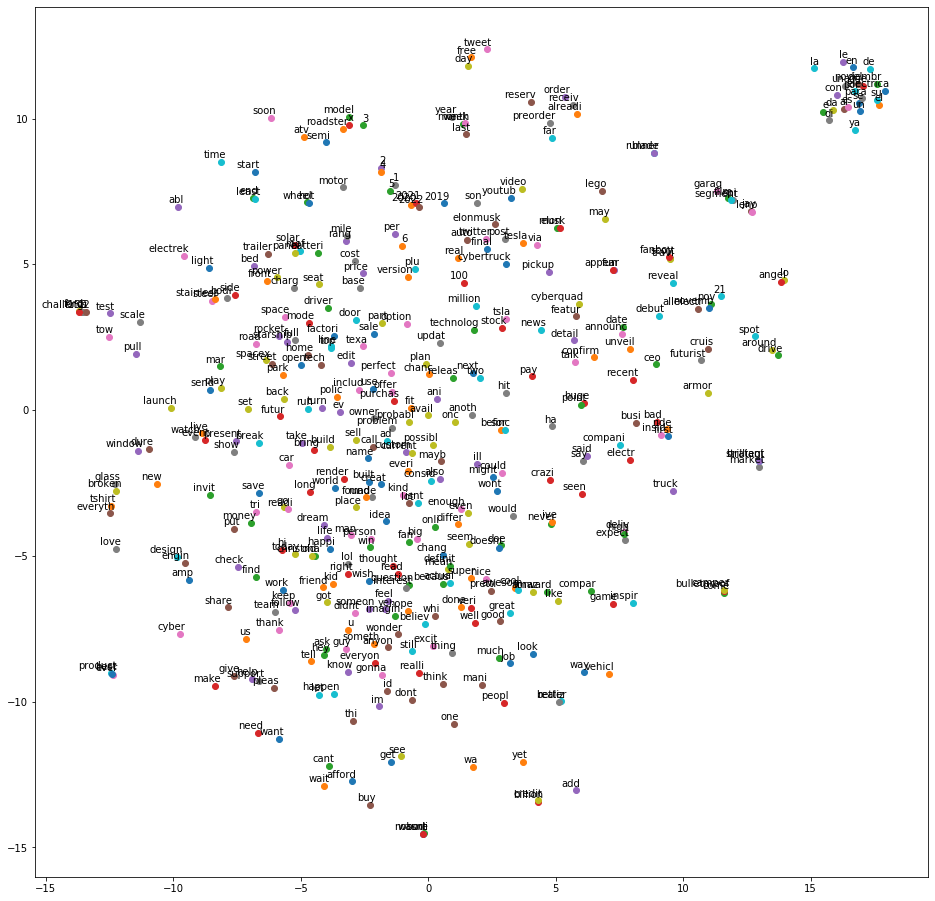

In [1501]:
# Get the first 500 most frequent words and remove stop words
stop_words = stopwords.words('english')
fre_words = pd.Series(all_words).value_counts().index[0:500]
filtered_words = [w for w in fre_words if not w in stop_words]
filtered_words_dict = {key: w2v_model.wv.vocab[key] for key in filtered_words}
# Plot
tsne_plot(w2v_model, filtered_words_dict)

## Convert tweets into 100 dimension vector using Word2Vec

In [654]:
import numpy as np

In [655]:
len(tweets_in_words)

9675

In [656]:
# Each tweet is represented by a 100 dimension vector derived from adding all word vector together in that tweet
tweets_vec = []
tweet_vec = np.zeros(100)
for tweet in tweets_in_words:
    for word in tweet:
        try:
            tweet_vec = tweet_vec + w2v_model[word]
        except:
            continue  #some words are not in the model vocabulary, we assume its vector is 0 * 100 dimension
    tweets_vec.append(tweet_vec)
    tweet_vec = np.zeros(100)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [657]:
twitter_vec = pd.DataFrame(tweets_vec)
twitter_vec.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.959023,0.065967,0.275525,5.231746,0.746932,0.421167,-3.175543,0.722779,1.456853,1.825673,...,-2.695926,-4.465526,0.350095,-2.908080,-0.705964,-3.081987,-4.213480,-0.097893,-0.296517,-3.863626
1,2.674873,-0.927167,-2.594637,2.684102,3.903527,0.089208,-0.744388,0.159171,2.538514,1.292500,...,0.132310,-0.966421,-1.266334,-2.955292,-1.909024,-2.332015,-3.086348,-0.615802,-1.204873,-1.441706
2,0.539945,-1.621762,-0.578767,3.490031,-1.392970,-1.674293,1.092133,-0.811078,2.064335,1.761377,...,0.795427,-2.911276,0.591862,-2.079280,-0.944292,-2.091031,-4.309038,0.546029,-2.224529,-3.836540
3,0.562220,-1.962597,-0.802992,3.616890,-1.255857,-1.973831,1.253069,-1.218941,2.105017,1.950185,...,0.787855,-2.807385,0.580126,-2.021669,-1.100780,-2.259413,-4.587194,0.457474,-2.467664,-3.902548
4,7.910802,0.442263,-1.107172,6.878643,3.692615,-0.807381,-1.728238,0.149582,0.987434,3.026488,...,-1.934048,-1.994551,-3.354637,-3.410816,-2.387926,-3.513068,-8.455780,-0.490581,-2.006670,-3.165003


In [658]:
twitter_vec.shape

(9675, 100)

## Extract other features
- date
- sentiment
- length
- retweet

In [659]:
from textblob import TextBlob

In [660]:
tweets.shape

(9675, 7)

In [661]:
tweets.head()

,id,username,created_at,tweet,retweet_count,place,location
0,1,NorwegianRoad,2019-10-14 22:18:40,@elonmusk @Tesla Cybertruck will look like arm...,0,,
1,2,55Sun5,2019-10-14 20:51:57,Elon Musk gave another hint about the Tesla Pi...,0,,
2,3,worldnewsdotcom,2019-10-14 20:38:07,Elon Musk says Tesla ‘cybertruck’ to be unlike...,0,,
3,4,TeslaForThe_Win,2019-10-14 20:33:49,Elon Musk says Tesla 'cybertruck' to be unlike...,0,,
4,5,paulsbusiness,2019-10-14 20:20:30,It’s the front right camera angle. Truck is so...,0,,


In [662]:
# Extract date
tweets_copy = tweets.copy()
split_date = tweets_copy['created_at'].str.split(' ', expand = True)
tweets_copy['date'] = split_date[0]

In [663]:
# Calculate sentiment and length
sentiment = []
length = []
for i in range(len(tweets_copy)):
    sentiment.append(TextBlob(tweets_copy.loc[i]["tweet"]).sentiment.polarity)
    length.append(len(tweets_copy.loc[i]["tweet"]))
tweets_copy['sentiment'] = sentiment
tweets_copy['length'] = length

In [664]:
# Final tweets table
tweets_final = tweets_copy.drop(['id','username','created_at','tweet','place','location'], axis=1)
tweets_final = pd.concat([tweets_final,twitter_vec], axis=1)
tweets_final.index = tweets_final['date']
tweets_final.drop(['date'],axis=1,inplace=True)
tweets_final.head()

,retweet_count,sentiment,length,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
date,,,,,,,,,,,,,,,,,,,,,
2019-10-14,0,0.100000,128,2.959023,0.065967,0.275525,5.231746,0.746932,0.421167,-3.175543,...,-2.695926,-4.465526,0.350095,-2.908080,-0.705964,-3.081987,-4.213480,-0.097893,-0.296517,-3.863626
2019-10-14,0,0.000000,121,2.674873,-0.927167,-2.594637,2.684102,3.903527,0.089208,-0.744388,...,0.132310,-0.966421,-1.266334,-2.955292,-1.909024,-2.332015,-3.086348,-0.615802,-1.204873,-1.441706
2019-10-14,0,-0.125000,225,0.539945,-1.621762,-0.578767,3.490031,-1.392970,-1.674293,1.092133,...,0.795427,-2.911276,0.591862,-2.079280,-0.944292,-2.091031,-4.309038,0.546029,-2.224529,-3.836540
2019-10-14,0,-0.125000,119,0.562220,-1.962597,-0.802992,3.616890,-1.255857,-1.973831,1.253069,...,0.787855,-2.807385,0.580126,-2.021669,-1.100780,-2.259413,-4.587194,0.457474,-2.467664,-3.902548
2019-10-14,0,0.006032,181,7.910802,0.442263,-1.107172,6.878643,3.692615,-0.807381,-1.728238,...,-1.934048,-1.994551,-3.354637,-3.410816,-2.387926,-3.513068,-8.455780,-0.490581,-2.006670,-3.165003


## Import stock price history

In [1233]:
# Read data from csv file downloaded from Yahoo Finance
stock_price = pd.read_csv('TSLA.csv')
sp = stock_price[['Date','Adj Close']]
sp.head()

,Date,Adj Close
0,2019-10-01,244.690002
1,2019-10-02,243.130005
2,2019-10-03,233.029999
3,2019-10-04,231.429993
4,2019-10-07,237.720001


In [1227]:
# Define a function to tag the degree of change of stock price
# <-15%(0),-15% to -5%(1), -5% to 0(2), 0 to 5%(3), 5% to 15%(4), >15%+(5)
def pct_label(x):
    if x<=-0.15:
        return 0
    elif x >-0.15 and x<=-0.05:
        return 1
    elif x>-0.05 and x<0:
        return 2
    elif x==0:
        return 3
    elif x>0.05 and x<=0.15:
        return 4
    elif x>0.15:
        return 5
    else:
        return 0 

In [1253]:
# Get label of how much stock price changes
sp['diff_1'] = sp['Adj Close'].shift(-lag) - sp['Adj Close']
sp = sp.round(5)
sp['direction'] = (sp['diff_1']/sp['Adj Close']).apply(pct_label)
sp.index = sp['Date']
sp.drop(['Date'],axis=1,inplace=True)
sp.head()

,Adj Close,diff_1,direction
Date,,,
2019-10-01,244.69000,-4.64000,2
2019-10-02,243.13000,1.40000,0
2019-10-03,233.03000,11.71000,4
2019-10-04,231.42999,16.46001,4
2019-10-07,237.72000,19.23999,4


## Data group by date

In [1]:
from sklearn.preprocessing import StandardScaler

In [1343]:
# Get vector of every day by suming the vectors on each day
tweets_date = tweets_final.groupby(tweets_final.index).sum()
# Get feasures: average sentiment and number of tweets of the day
tweets_date['avg_sentiment'] = tweets_final['sentiment'].groupby(tweets_final.index).mean()
tweets_date['num_tweets'] = tweets_final['sentiment'].groupby(tweets_final.index).count()
#tweets_date.drop(['sentiment','length'],axis=1,inplace=True)
tweets_date = tweets_date.round(5)

In [1344]:
# Standardized X table
tweets_date_s = tweets_date.copy()
columns = tweets_date_s.columns.values.tolist()
tweets_date_s[columns] = StandardScaler().fit_transform(tweets_date_s[columns])
tweets_date_s.columns = columns
tweets_date_s.index = tweets_date.index

In [1345]:
# Join stardardized X with y table
tweets_join = tweets_date_s.join(sp, how='inner')
tweets_join.head(6)

,retweet_count,sentiment,length,0,1,2,3,4,5,6,...,95,96,97,98,99,avg_sentiment,num_tweets,Adj Close,diff_1,direction
2019-10-14,-0.141087,-1.517707,-0.891145,-1.287504,-0.295005,0.539464,-0.513084,-0.915070,0.828638,0.150727,...,0.815693,0.906744,-1.442225,0.113318,0.685786,-1.458625,-0.738793,256.95999,-3.45999,2
2019-10-15,-0.221180,-1.376573,-1.570848,-1.622868,0.483686,0.898489,-1.544630,-0.987301,1.547610,0.052017,...,1.353422,1.586679,-1.047742,1.168748,1.592300,-0.981158,-1.572365,257.89002,-2.31002,2
2019-10-16,-0.215248,-1.370472,-1.772371,-1.896884,0.688395,1.228172,-1.824504,-1.207309,1.777541,0.312477,...,1.647295,1.901919,-1.206725,1.397223,1.868558,0.011253,-1.840299,259.75000,-5.07001,2
2019-10-17,-0.216731,-1.390786,-1.838186,-1.847537,0.736174,1.206283,-1.773779,-1.244879,1.618591,0.401936,...,1.646625,1.850995,-1.180604,1.341901,1.829129,-0.653394,-1.780758,261.97000,37.70999,4
2019-10-18,-0.222664,-1.400540,-1.919145,-1.893939,0.751067,1.294351,-1.839882,-1.387932,1.703588,0.320484,...,1.727600,1.951222,-1.199815,1.462047,1.857089,2.413420,-1.929610,256.95001,71.17999,5
2019-10-21,-0.222664,-1.464721,-1.945160,-1.956377,0.723410,1.274737,-1.889399,-1.376678,1.765977,0.338018,...,1.747448,1.985638,-1.174210,1.448110,1.898417,-1.382170,-1.929610,253.50000,74.20999,5


## PCA and Multinomial Logistic Regression

In [1296]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [1346]:
tweets_date_vec = tweets_date.drop(['retweet_count','avg_sentiment','num_tweets','sentiment','length'], axis=1)
# Standardize
columns = tweets_date_vec.columns.values.tolist()
tweets_date_vec[columns] = StandardScaler().fit_transform(tweets_date_vec)
tweets_date_vec.columns = columns
tweets_date_vec.index = tweets_date.index
tweets_date_vec.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
date,,,,,,,,,,,,,,,,,,,,,
2019-10-14,-1.287504,-0.295005,0.539464,-0.513084,-0.915070,0.828638,0.150727,1.059113,-0.723601,-0.905838,...,-1.339928,-0.360791,1.767640,1.173936,1.213543,0.815693,0.906744,-1.442225,0.113318,0.685786
2019-10-15,-1.622868,0.483686,0.898489,-1.544630,-0.987301,1.547610,0.052017,1.019770,-1.291670,-1.519903,...,-1.257486,1.422921,1.615934,1.572272,1.473805,1.353422,1.586679,-1.047742,1.168748,1.592300
2019-10-16,-1.896884,0.688395,1.228172,-1.824504,-1.207309,1.777541,0.312477,1.214156,-1.596892,-1.870541,...,-1.380298,1.767658,1.830316,1.855140,1.834079,1.647295,1.901919,-1.206725,1.397223,1.868558
2019-10-17,-1.847537,0.736174,1.206283,-1.773779,-1.244879,1.618591,0.401936,1.345173,-1.552382,-1.844344,...,-1.352795,1.808921,1.888234,1.844295,1.879634,1.646625,1.850995,-1.180604,1.341901,1.829129
2019-10-18,-1.893939,0.751067,1.294351,-1.839882,-1.387932,1.703588,0.320484,1.336828,-1.643463,-1.883747,...,-1.407439,1.845882,1.854390,1.911688,1.876251,1.727600,1.951222,-1.199815,1.462047,1.857089


In [1347]:
# Fit PCA and select the first 2 primary components
pca = PCA(n_components=2)
pca.fit(tweets_date_vec)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [1348]:
#print(pca.components_)
print(pca.explained_variance_)

[69.62364273 16.38495166]


In [1349]:
X_pca = pca.transform(tweets_date_vec)
X = np.array(tweets_date_vec)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (147, 100)
transformed shape: (147, 2)


In [1352]:
# Get new X
pca_Df = pd.DataFrame(data = X_pca.round(5), columns = ['PC1', 'PC2'])
pca_Df.index = tweets_date_vec.index
pca_Df = pca_Df.join(tweets_date[['retweet_count','avg_sentiment','num_tweets','sentiment','length']])
pca_Df = pca_Df.join(sp, how='inner')
pca_Df.head(6)

,PC1,PC2,retweet_count,avg_sentiment,num_tweets,sentiment,length,Adj Close,diff_1,direction
2019-10-14,6.88926,1.70660,55,-0.00763,41,-0.31272,5526,256.95999,-3.45999,2
2019-10-15,12.84813,1.75080,1,0.04002,13,0.52024,2025,257.89002,-2.31002,2
2019-10-16,15.38168,1.67724,5,0.13906,4,0.55625,987,259.75000,-5.07001,2
2019-10-17,15.24087,1.26000,4,0.07273,6,0.43636,648,261.97000,37.70999,4
2019-10-18,15.85372,1.17986,0,0.37879,1,0.37879,231,256.95001,71.17999,5
2019-10-21,16.12937,1.44425,0,0.00000,1,0.00000,97,253.50000,74.20999,5


In [1429]:
# Interaction term
pca_Df['ret_sen'] = (pca_Df['retweet_count']+1) * pca_Df['avg_sentiment']

In [1430]:
pca_Df.head()

,PC1,PC2,retweet_count,avg_sentiment,num_tweets,sentiment,length,Adj Close,diff_1,direction,ret_sen
2019-10-14,6.88926,1.70660,55,-0.00763,41,-0.31272,5526,256.95999,-3.45999,2,-0.42728
2019-10-15,12.84813,1.75080,1,0.04002,13,0.52024,2025,257.89002,-2.31002,2,0.08004
2019-10-16,15.38168,1.67724,5,0.13906,4,0.55625,987,259.75000,-5.07001,2,0.83436
2019-10-17,15.24087,1.26000,4,0.07273,6,0.43636,648,261.97000,37.70999,4,0.36365
2019-10-18,15.85372,1.17986,0,0.37879,1,0.37879,231,256.95001,71.17999,5,0.37879


In [1431]:
# Standardize X
pca_Df_s = pca_Df[['PC1','PC2','retweet_count','avg_sentiment','num_tweets','sentiment','length','ret_sen']]
columns = pca_Df_s.columns.values.tolist()
pca_Df_s[columns] = StandardScaler().fit_transform(pca_Df_s)
pca_Df_s.columns = columns
pca_Df_s.index = pca_Df.index
pca_Df_s.head(6)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,PC1,PC2,retweet_count,avg_sentiment,num_tweets,sentiment,length,ret_sen
2019-10-14,0.875830,0.349142,-0.145138,-1.425031,-0.790268,-1.479222,-0.934700,-0.243091
2019-10-15,1.587801,0.358891,-0.211806,-0.977786,-1.627479,-1.346777,-1.610802,-0.237216
2019-10-16,1.890512,0.342667,-0.206868,-0.048194,-1.896583,-1.341051,-1.811258,-0.228479
2019-10-17,1.873688,0.250643,-0.208102,-0.670769,-1.836782,-1.360114,-1.876724,-0.233931
2019-10-18,1.946912,0.232967,-0.213041,2.201921,-1.986284,-1.369268,-1.957254,-0.233756
2019-10-21,1.979847,0.291280,-0.213041,-1.353416,-1.986284,-1.429498,-1.983132,-0.238143


In [1495]:
# Split the training and test dataset
X = pca_Df_s[['PC1','PC2','avg_sentiment','retweet_count','num_tweets','ret_sen']]
y = pca_Df['direction']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=318)

In [1496]:
# Fit Multinomial Logistic Regression
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(y_pred)
log_reg.score(X_test, y_test)

[4 4 4 4 4 0 0 4 4 4 0 4 0 4 4 0 4 4 0 4]


0.6